In [1139]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 12]


In [1157]:
class Engine:
    def __init__(self, initial_cash=100000):
        self.strategy = None
        self.initial_cash=initial_cash
        self.cash = initial_cash
        self.data = None
        self.current_idx = None
        self.cash_series = {}#maps current idx to current cash amount
        self.stock_series = {}#maps current idx to current holdings

    def add_data(self, data: pd.DataFrame):
        self.data = data

    def add_strategy(self, strategy):
        self.strategy = strategy()  # Create an instance of the strategy

    def run(self):
        self.strategy.data = self.data
        self.strategy.cash = self.cash
        for idx in tqdm(self.data.index):
            self.current_idx = idx
            self.strategy.current_idx = self.current_idx
            self._fill_orders()
            self.strategy.on_bar()
            self.cash_series[idx] = self.cash
            self.stock_series[idx] = self.strategy.position_size * self.data.loc[self.current_idx]['Close']
        print("BackTesting Results : ")
        return self._get_stats()
        
    def _fill_orders(self):
        for order in self.strategy.orders:
            fill_price = self.data.loc[self.current_idx]['Open']
            can_fill = False
            if order.side == 'buy' :
                if order.type=='limit':
                    if self.data.loc[self.current_idx]['Low']<=order.limit_price: #Condition of limit order
                        fill_price=min(order.limit_price ,  self.data.loc[self.current_idx]['Open'])
                        if self.cash >= order.size * fill_price:
                            can_fill = True
                            print(f"{self.current_idx} Buy Filled. Limit: {order.limit_price:.2f}, Fill: {fill_price:.2f}, Low: {self.data.loc[self.current_idx]['Low']:.2f}")
                        else:
                            print(f"{self.current_idx} Buy NOT filled. Limit: {order.limit_price:.2f}, Low: {self.data.loc[self.current_idx]['Low']:.2f}")
                    else:
                        print(f"{self.current_idx} Buy NOT filled. Limit: {order.limit_price:.2f}, Low: {self.data.loc[self.current_idx]['Low']:.2f}")
                elif self.cash >= self.data.loc[self.current_idx]['Open'] * order.size:
                    can_fill=True
                    print(f"{self.current_idx} Buy Done ")

                else:
                    print(f"{self.current_idx} Buy NOT Done. Insufficient cash.")

                
                    
            elif order.side == 'sell': 
                if order.type=='limit':
                    if self.data.loc[self.current_idx]['High']>=order.limit_price:
                        fill_price = max(order.limit_price, self.data.loc[self.current_idx]['Open'])
                        if self.strategy.position_size >= abs(order.size):
                            can_fill = True
                            print(f"{self.current_idx} Sell Filled. Limit: {order.limit_price:.2f}, Fill: {fill_price:.2f}, High: {self.data.loc[self.current_idx]['High']:.2f}")
                        else:
                            print(f"{self.current_idx} Sell NOT filled. Limit: {order.limit_price:.2f}, High: {self.data.loc[self.current_idx]['High']:.2f}")
                    else:
                        print(f"{self.current_idx} Sell NOT filled. Limit: {order.limit_price:.2f}, High: {self.data.loc[self.current_idx]['High']:.2f}")
                elif self.strategy.position_size>=abs(order.size):
                    can_fill=True
                    print(f"{self.current_idx} Sell Done.")
                else:
                    print(f"{self.current_idx} Sell NOT Done. Insufficient position size.")
            if can_fill:
                t = Trade(ticker=order.ticker, side=order.side, price=self.data.loc[self.current_idx]['Open'],
                          size=order.size, idx=self.current_idx,type=order.type)
                self.strategy.trades.append(t)
                self.cash -= t.price * t.size
                self.strategy.cash = self.cash

        self.strategy.orders = [] #limit orders only valid for that day and cleared if not possible to do that

        
    def _get_stats(self):
        metrics = {}
        total_return = 100 *((self.data.loc[self.current_idx]['Close'] * self.strategy.position_size + self.cash) / self.initial_cash -1)
        metrics['total_return'] = total_return
        portfolio_bh = self.initial_cash / self.data.loc[self.data.index[0]]['Open'] * self.data.Close        #A buy and hold benchmark to compare against
        portfolio = pd.DataFrame({'stock':self.stock_series, 'cash':self.cash_series})#Current portfolio status
        portfolio['total_aum'] = portfolio['stock'] + portfolio['cash']#Total cash 
        metrics['exposure_pct'] = ((portfolio['stock'] / portfolio['total_aum']) * 100).mean()#Amount of money at risk
        p = portfolio.total_aum
        p_bh=portfolio_bh
        metrics['returns_annualised']=(((p.iloc[-1]/p.iloc[0])**(365/((p.index[-1]-p.index[0])).days))-1)*100
        metrics['returns_bh_annualized'] = ((p_bh.iloc[-1] / p_bh.iloc[0]) ** (1 / ((p_bh.index[-1] - p_bh.index[0]).days / 365)) - 1) * 100
        trading_days=252#(for stock)
        metrics['volatility_annualised']=p.pct_change().std() * np.sqrt(trading_days)*100
        metrics['volatility_bh_annualised']=p_bh.pct_change().std() * np.sqrt(trading_days)*100
        risk_free_rate=0.04
        metrics['sharpe_ratio']=(metrics['returns_annualised']-risk_free_rate)/metrics['volatility_annualised']
        metrics['bh_sharpe_ratio']=(metrics['returns_bh_annualized']-risk_free_rate)/metrics['volatility_bh_annualised']
        self.portfolio = portfolio
        self.portfolio_bh = portfolio_bh
        metrics['max_drawdown'] = get_max_drawdown(portfolio.total_aum)
        metrics['max_drawdown_bh'] = get_max_drawdown(portfolio_bh)
        return metrics

    def plot(self):
        plt.plot(self.portfolio['total_aum'],label='Strategy')
        plt.plot(self.portfolio_bh,label='Buy & Hold')
        plt.show()



In [1159]:
class Strategy:
    def __init__(self):
        self.current_idx = None
        self.data = None
        self.cash = None
        self.orders = []
        self.trades = []


    def buy(self, ticker, size=1):
        self.orders.append(Order(ticker=ticker, side='buy', size=size, idx=self.current_idx))

    def sell(self, ticker, size=1):
        self.orders.append(Order(ticker=ticker, side='sell', size=-size, idx=self.current_idx))

    def buy_limit(self,ticker,limit_price,size=1):
        self.orders.append(Order(ticker=ticker,side='buy',size=size,idx=self.current_idx,order_type='limit',limit_price=limit_price))
    
    def sell_limit(self,ticker,limit_price,size=1):
        self.orders.append(Order(ticker=ticker,side='sell',size=-size,idx=self.current_idx,order_type='limit',limit_price=limit_price))

    def close(self):
        return self.data.loc[self.current_idx]['Close']

    def on_bar(self):
        pass
        
    @property
    def position_size(self):
        return sum([t.size for t in self.trades])


In [1161]:
class Trade:
    def __init__(self, ticker, side,price,size, idx,type ):
        self.ticker = ticker
        self.side = side
        self.size = size
        self.idx = idx
        self.type = type
        self.price = price

class Order:
    def __init__(self, ticker, side, size, idx, price=None,limit_price=None, order_type="Market"):
        self.ticker = ticker
        self.side = side
        self.size = size
        self.idx = idx
        self.price = price
        self.limit_price=limit_price
        self.type=order_type


In [1163]:
    def get_max_drawdown(close):
        roll_max=close.cummax() # a new series
        daily_drawdown=close/roll_max -1.0 #a new series
        max_daily_drawdown = daily_drawdown.cummin() # a new series
        return max_daily_drawdown.min() * 100 #final answer

In [1165]:
class BuyAndSellSwitch(Strategy):
    def __init__(self):
        super().__init__()
    def on_bar(self):
        if self.position_size == 0:
            limit_price = self.close() * 0.995
            self.buy_limit('AAPL', size=100, limit_price=limit_price)
            print(f"{self.current_idx} Buy order placed. Limit: {limit_price:.2f}")
        else:
            limit_price = self.close() * 1.005
            self.sell_limit('AAPL', size=100, limit_price=limit_price)
            print(f"{self.current_idx} Sell order placed. Limit: {limit_price:.2f}")



In [1167]:
import yfinance as yf
data = yf.Ticker('AAPL').history(start='2023-12-01', end='2023-12-31', interval='1d')
e = Engine()
e.add_data(data)
e.add_strategy(BuyAndSellSwitch)


In [1169]:
e.run()   

100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1511.71it/s]

2023-12-01 00:00:00-05:00 Buy order placed. Limit: 189.56
2023-12-04 00:00:00-05:00 Buy Filled. Limit: 189.56, Fill: 189.26, Low: 186.74
2023-12-04 00:00:00-05:00 Sell order placed. Limit: 189.66
2023-12-05 00:00:00-05:00 Sell Filled. Limit: 189.66, Fill: 189.66, High: 193.67
2023-12-05 00:00:00-05:00 Buy order placed. Limit: 191.73
2023-12-06 00:00:00-05:00 Buy Filled. Limit: 191.73, Fill: 191.73, Low: 191.38
2023-12-06 00:00:00-05:00 Sell order placed. Limit: 192.55
2023-12-07 00:00:00-05:00 Sell Filled. Limit: 192.55, Fill: 192.90, High: 194.26
2023-12-07 00:00:00-05:00 Buy order placed. Limit: 192.57
2023-12-08 00:00:00-05:00 Buy NOT filled. Limit: 192.57, Low: 192.94
2023-12-08 00:00:00-05:00 Buy order placed. Limit: 194.00
2023-12-11 00:00:00-05:00 Buy Filled. Limit: 194.00, Fill: 192.38, Low: 190.70
2023-12-11 00:00:00-05:00 Sell order placed. Limit: 193.41
2023-12-12 00:00:00-05:00 Sell Filled. Limit: 193.41, Fill: 193.41, High: 193.98
2023-12-12 00:00:00-05:00 Buy order placed

{'total_return': -0.5668421303921312,
 'exposure_pct': 10.659959695153116,
 'returns_annualised': -7.142315642117447,
 'returns_bh_annualized': 9.159145482834585,
 'volatility_annualised': 1.6804548659928964,
 'volatility_bh_annualised': 14.620023707644838,
 'sharpe_ratio': -4.274030673161684,
 'bh_sharpe_ratio': 0.6237435496131355,
 'max_drawdown': -0.5896219427888871,
 'max_drawdown_bh': -2.8166134952022026}

In [1183]:
class SMACrossover(Strategy):
    def on_bar(self):
        if self.position_size == 0:
            if self.data.loc[self.current_idx].sma_12 > self.data.loc[self.current_idx].sma_24:
                limit_price = self.close() * 0.995
                # BUY AS MANY SHARES AS WE CAN!
                order_size = int(self.cash / limit_price)
                self.buy_limit('SPY', size=order_size, limit_price=limit_price)
        elif self.data.loc[self.current_idx].sma_12 < self.data.loc[self.current_idx].sma_24:
            limit_price = self.close() * 1.005
            self.sell_limit('SPY', size=self.position_size, limit_price=limit_price)
            
data = yf.Ticker('SPY').history(start='2020-12-01', end='2023-12-31', interval='1d')
e = Engine(initial_cash=1000)

data['sma_12'] = data.Close.rolling(12).mean()
data['sma_24'] = data.Close.rolling(24).mean()
e.add_data(data)

e.add_strategy(SMACrossover)
stats = e.run()
print(stats)

100%|███████████████████████████████████████| 775/775 [00:00<00:00, 6742.58it/s]

2021-01-06 00:00:00-05:00 Buy Filled. Limit: 350.12, Fill: 350.12, Low: 349.78
2021-03-08 00:00:00-05:00 Sell Filled. Limit: 365.35, Fill: 365.35, High: 367.37
2021-03-19 00:00:00-04:00 Buy Filled. Limit: 369.12, Fill: 369.12, Low: 368.07
2021-05-18 00:00:00-04:00 Sell NOT filled. Limit: 397.02, High: 395.56
2021-05-19 00:00:00-04:00 Sell NOT filled. Limit: 393.60, High: 390.79
2021-05-20 00:00:00-04:00 Sell Filled. Limit: 392.57, Fill: 392.57, High: 396.10
2021-06-02 00:00:00-04:00 Buy NOT filled. Limit: 396.99, Low: 398.63
2021-06-03 00:00:00-04:00 Buy Filled. Limit: 397.62, Fill: 397.26, Low: 395.77
2021-09-22 00:00:00-04:00 Sell Filled. Limit: 417.01, Fill: 417.25, High: 421.06
2021-10-20 00:00:00-04:00 Buy NOT filled. Limit: 429.06, Low: 431.57
2021-10-21 00:00:00-04:00 Buy NOT filled. Limit: 430.74, Low: 431.85
2021-10-22 00:00:00-04:00 Buy Filled. Limit: 431.86, Fill: 431.86, Low: 431.60
2021-12-03 00:00:00-05:00 Sell Filled. Limit: 439.87, Fill: 439.87, High: 440.45
2021-12-21 

In [1185]:
e._get_stats()

{'total_return': 0.8671922855156833,
 'exposure_pct': 47.35906559216523,
 'returns_annualised': 0.28103586509187206,
 'returns_bh_annualized': 10.599050694354117,
 'volatility_annualised': 9.662235477188561,
 'volatility_bh_annualised': 17.41413775996798,
 'sharpe_ratio': 0.02494617996641981,
 'bh_sharpe_ratio': 0.6063493260417123,
 'max_drawdown': -21.616575618939738,
 'max_drawdown_bh': -24.496385819821352}

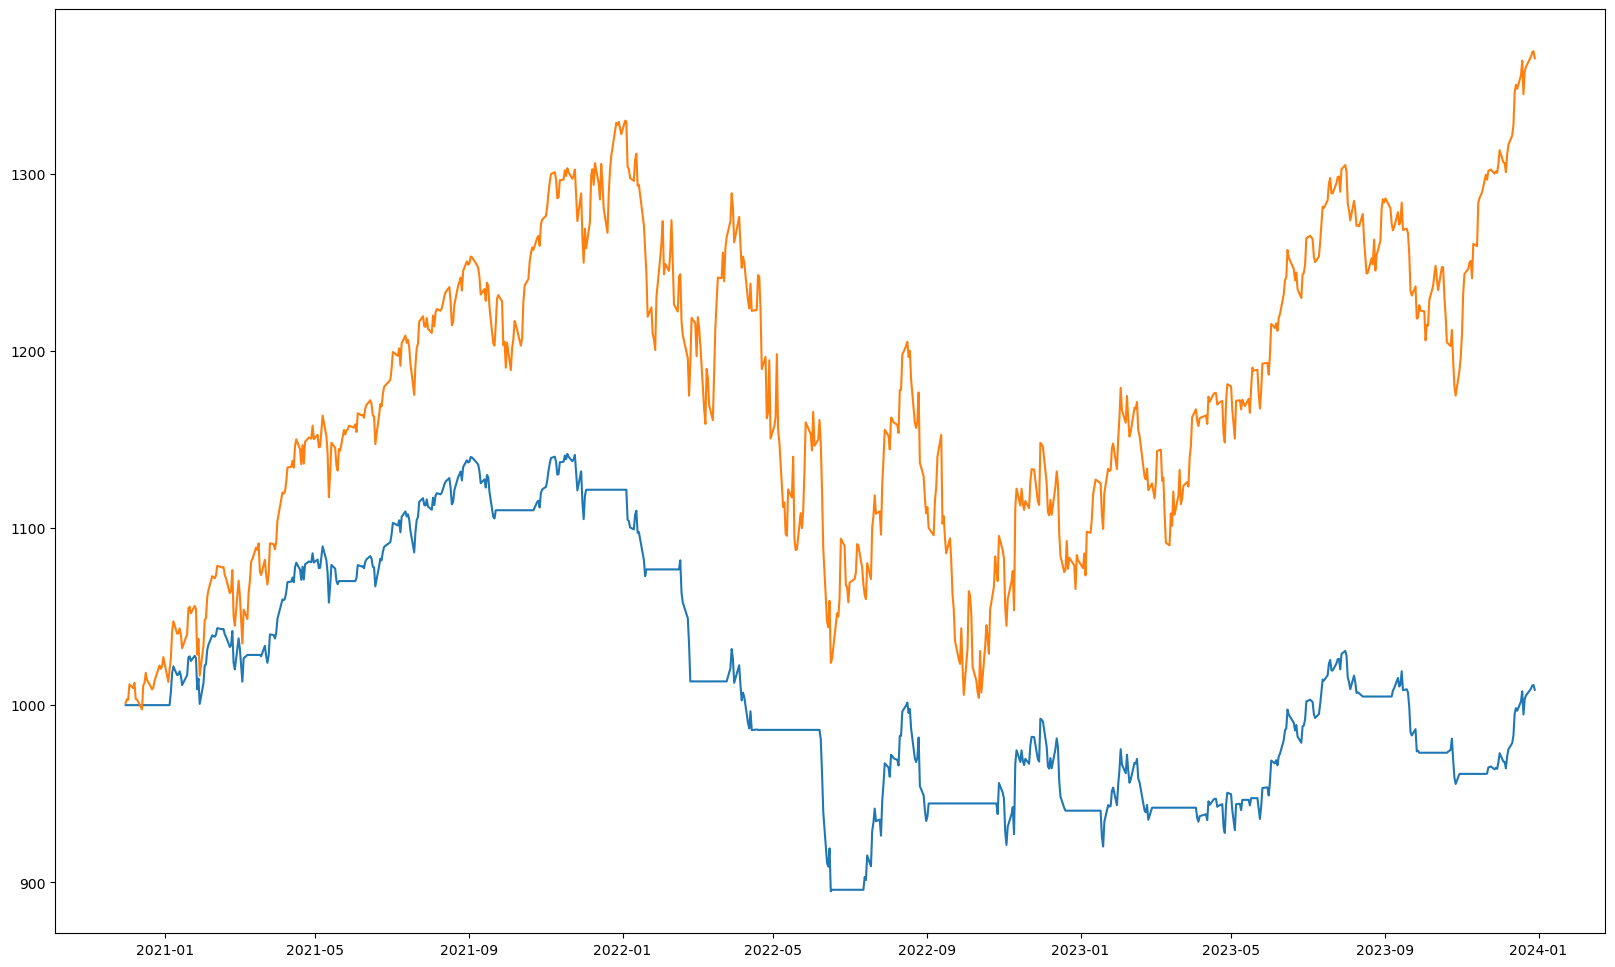

In [1187]:
e.plot()

In [1209]:

class BuyAndSellStrategy(Strategy):
    def __init__(self):
        super().__init__()

    def on_bar(self):
        if self.position_size == 0:
            self.buy('SPY', 100)
            print(self.current_idx, "buy")
        else:
            self.sell('SPY', 100)
            print(self.current_idx, "sell")

# Main execution
data = yf.Ticker('SPY').history(start='2020-12-01', end='2022-12-31', interval='1d')
e = Engine()
e.add_strategy(BuyAndSellStrategy)  # Pass the class, not an instance
e.add_data(data)
e.run()

100%|███████████████████████████████████████| 525/525 [00:00<00:00, 5507.92it/s]

2020-12-01 00:00:00-05:00 buy
2020-12-02 00:00:00-05:00 Buy Done 
2020-12-02 00:00:00-05:00 sell
2020-12-03 00:00:00-05:00 Sell Done.
2020-12-03 00:00:00-05:00 buy
2020-12-04 00:00:00-05:00 Buy Done 
2020-12-04 00:00:00-05:00 sell
2020-12-07 00:00:00-05:00 Sell Done.
2020-12-07 00:00:00-05:00 buy
2020-12-08 00:00:00-05:00 Buy Done 
2020-12-08 00:00:00-05:00 sell
2020-12-09 00:00:00-05:00 Sell Done.
2020-12-09 00:00:00-05:00 buy
2020-12-10 00:00:00-05:00 Buy Done 
2020-12-10 00:00:00-05:00 sell
2020-12-11 00:00:00-05:00 Sell Done.
2020-12-11 00:00:00-05:00 buy
2020-12-14 00:00:00-05:00 Buy Done 
2020-12-14 00:00:00-05:00 sell
2020-12-15 00:00:00-05:00 Sell Done.
2020-12-15 00:00:00-05:00 buy
2020-12-16 00:00:00-05:00 Buy Done 
2020-12-16 00:00:00-05:00 sell
2020-12-17 00:00:00-05:00 Sell Done.
2020-12-17 00:00:00-05:00 buy
2020-12-18 00:00:00-05:00 Buy Done 
2020-12-18 00:00:00-05:00 sell
2020-12-21 00:00:00-05:00 Sell Done.
2020-12-21 00:00:00-05:00 buy
2020-12-22 00:00:00-05:00 Buy Do

{'total_return': 0.05487407604383154,
 'exposure_pct': 19.527145882166888,
 'returns_annualised': 0.026384961629677406,
 'returns_bh_annualized': 3.7945797258429836,
 'volatility_annualised': 5.29668300747175,
 'volatility_bh_annualised': 19.140545027238222,
 'sharpe_ratio': -0.0025704838955090538,
 'bh_sharpe_ratio': 0.19615845423941566,
 'max_drawdown': -10.187727272662993,
 'max_drawdown_bh': -24.49637414398057}

In [1211]:
e._get_stats()

{'total_return': 0.05487407604383154,
 'exposure_pct': 19.527145882166888,
 'returns_annualised': 0.026384961629677406,
 'returns_bh_annualized': 3.7945797258429836,
 'volatility_annualised': 5.29668300747175,
 'volatility_bh_annualised': 19.140545027238222,
 'sharpe_ratio': -0.0025704838955090538,
 'bh_sharpe_ratio': 0.19615845423941566,
 'max_drawdown': -10.187727272662993,
 'max_drawdown_bh': -24.49637414398057}

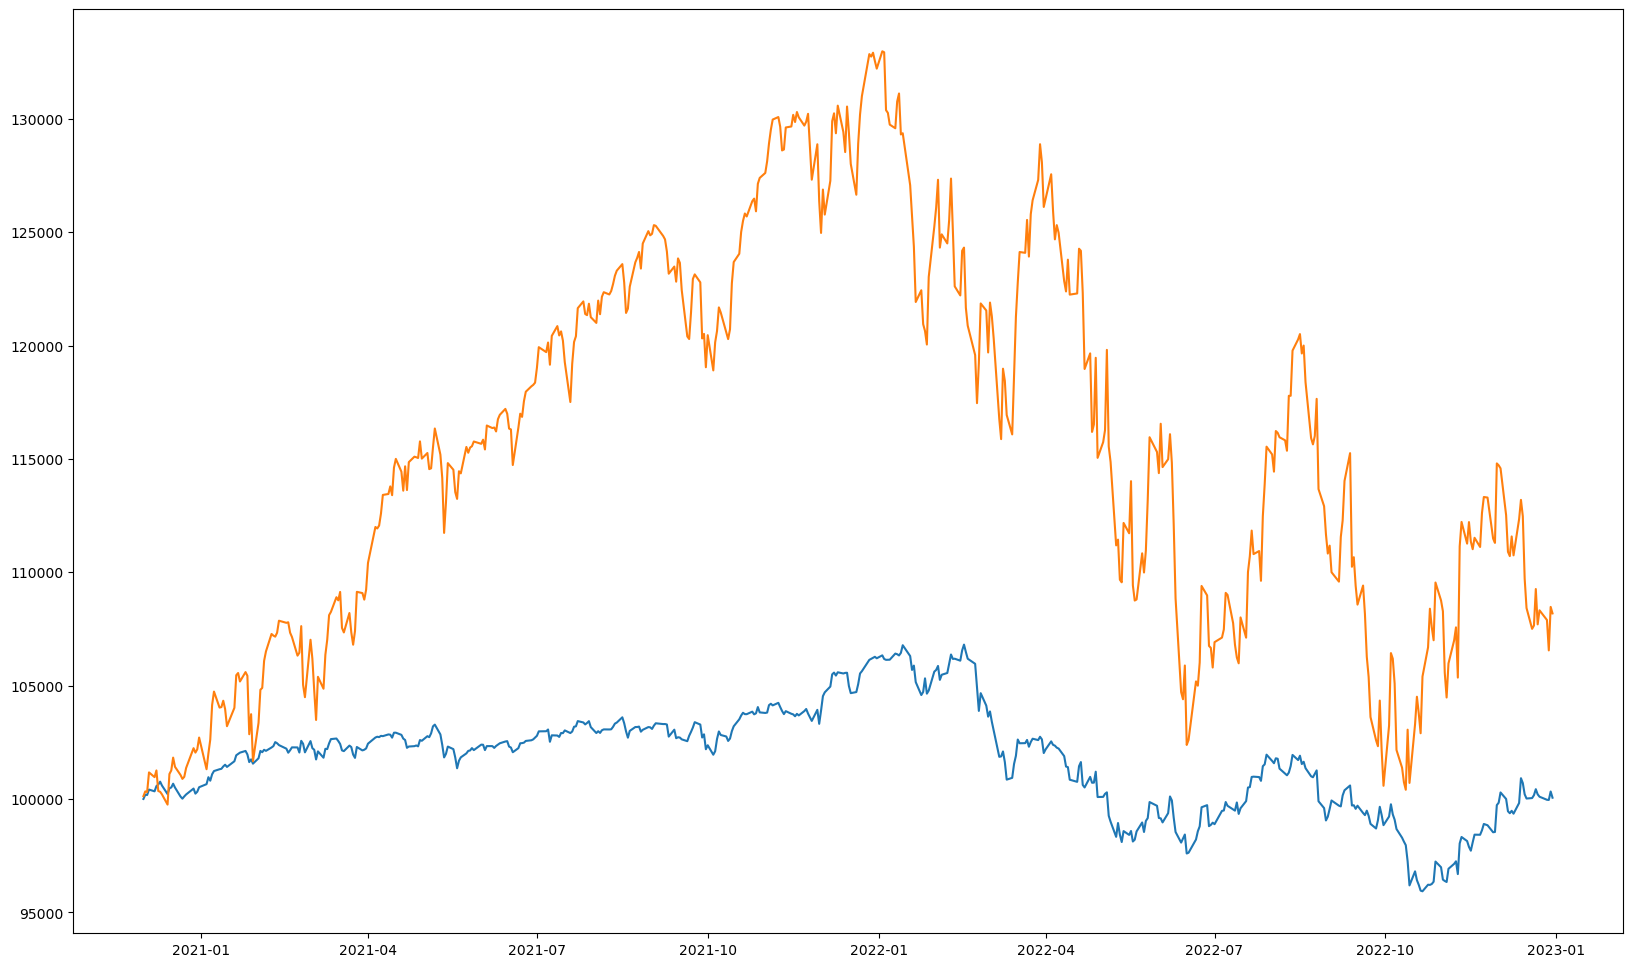

In [1213]:
e.plot()

In [1068]:
import yfinance as yf
class BuyAndSellSwitch(Strategy):
    def __init__(self):
        super().__init__()
    def on_bar(self):
        if self.position_size == 0:
            self.buy('AAPL', 1)
        else:
            self.sell('AAPL', 1)

data = yf.Ticker('AAPL').history(start='2022-12-01', end='2022-12-31', interval='1d')
e = Engine()
e.add_data(data)
e.add_strategy(BuyAndSellSwitch)
e.run()  

100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 4704.39it/s]

 New Cash: 100000.00
 Position_size: 0.00
2022-12-01 00:00:00-05:00: Cash: 100000.00, Position Size: 0
2022-12-02 00:00:00-05:00 Buy Done 
 New Cash: 99855.40
 Position_size: 1.00
2022-12-02 00:00:00-05:00: Cash: 99855.40, Position Size: 1
2022-12-05 00:00:00-05:00 Sell filled.
 New Cash: 100001.79
 Position_size: 0.00
2022-12-05 00:00:00-05:00: Cash: 100001.79, Position Size: 0
2022-12-06 00:00:00-05:00 Buy Done 
 New Cash: 99856.09
 Position_size: 1.00
2022-12-06 00:00:00-05:00: Cash: 99856.09, Position Size: 1
2022-12-07 00:00:00-05:00 Sell filled.
 New Cash: 99996.96
 Position_size: 0.00
2022-12-07 00:00:00-05:00: Cash: 99996.96, Position Size: 0
2022-12-08 00:00:00-05:00 Buy Done 
 New Cash: 99855.93
 Position_size: 1.00
2022-12-08 00:00:00-05:00: Cash: 99855.93, Position Size: 1
2022-12-09 00:00:00-05:00 Sell filled.
 New Cash: 99996.94
 Position_size: 0.00
2022-12-09 00:00:00-05:00: Cash: 99996.94, Position Size: 0
2022-12-12 00:00:00-05:00 Buy Done 
 New Cash: 99855.57
 Positio

{'total_return': -0.005191219487066245,
 'exposure_pct': 0.06509135485590781,
 'returns_annualised': -0.06531811690588807,
 'returns_bh_annualized': -81.08597345642872,
 'volatility_annualised': 0.03144906305597941,
 'volatility_bh_annualised': 29.45366240677332,
 'sharpe_ratio': -3.3488475226884047,
 'bh_sharpe_ratio': -2.75435945235023,
 'max_drawdown': -0.009282409956878901,
 'max_drawdown_bh': -15.01584419444476}

In [813]:
from backtesting import Backtest, Strategy

class BuyAndSellSwitch(Strategy):
    def init(self):
        pass
    def next(self):
        if self.position.size == 0:
            self.buy(size=1)
        else:
            self.sell(size=1)

bt = Backtest(data, BuyAndSellSwitch, cash=10000)
output = bt.run()
output

Start                     2022-12-01 00:00...
End                       2022-12-30 00:00...
Duration                     29 days 00:00:00
Exposure Time [%]                    90.47619
Equity Final [$]                  9986.298926
Equity Peak [$]                       10000.0
Return [%]                          -0.137011
Buy & Hold Return [%]              -12.392961
Return (Ann.) [%]                   -1.631796
Volatility (Ann.) [%]                0.296213
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.141271
Avg. Drawdown [%]                   -0.141271
Max. Drawdown Duration       28 days 00:00:00
Avg. Drawdown Duration       28 days 00:00:00
# Trades                                   10
Win Rate [%]                             40.0
Best Trade [%]                       1.030258
Worst Trade [%]                     -3.132287
Avg. Trade [%]                    

In [815]:
import pandas as pd
import yfinance as yf
from tqdm import tqdm

class Engine:
    def __init__(self, initial_cash=10000):
        self.strategy = None
        self.initial_cash = initial_cash
        self.cash = initial_cash
        self.data = None
        self.current_idx = None

    def add_data(self, data: pd.DataFrame):
        self.data = data

    def add_strategy(self, strategy):
        self.strategy = strategy()

    def run(self):
        self.strategy.data = self.data
        for idx in tqdm(self.data.index):
            self.current_idx = idx
            self.strategy.current_idx = self.current_idx
            self._fill_orders()
            self.strategy.on_bar()
            print(f"{idx}: Cash: {self.cash:.2f}, Position Size: {self.strategy.position_size}")

    def _fill_orders(self):
        for order in self.strategy.orders:
            can_fill = False
            fill_price = self.data.loc[self.current_idx]['Open']
            
            if order.side == 'buy':
                if order.type == 'limit':
                    if self.data.loc[self.current_idx]['Low'] <= order.limit_price:
                        fill_price = min(order.limit_price, self.data.loc[self.current_idx]['Open'])
                        can_fill = True
                        print(f"{self.current_idx} Buy Filled. Limit: {order.limit_price:.2f}, Fill: {fill_price:.2f}, Low: {self.data.loc[self.current_idx]['Low']:.2f}")
                    else:
                        print(f"{self.current_idx} Buy NOT filled. Limit: {order.limit_price:.2f}, Low: {self.data.loc[self.current_idx]['Low']:.2f}")
                else:
                    can_fill = True
                
                if can_fill and self.cash >= order.size * fill_price:
                    can_fill = True
                else:
                    can_fill = False
                    print(f"{self.current_idx} Buy NOT filled. Insufficient cash.")
            
            elif order.side == 'sell':
                if order.type == 'limit':
                    if self.data.loc[self.current_idx]['High'] >= order.limit_price:
                        fill_price = max(order.limit_price, self.data.loc[self.current_idx]['Open'])
                        can_fill = True
                        print(f"{self.current_idx} Sell Filled. Limit: {order.limit_price:.2f}, Fill: {fill_price:.2f}, High: {self.data.loc[self.current_idx]['High']:.2f}")
                    else:
                        print(f"{self.current_idx} Sell NOT filled. Limit: {order.limit_price:.2f}, High: {self.data.loc[self.current_idx]['High']:.2f}")
                else:
                    can_fill = True
                
                if can_fill and self.strategy.position_size >= abs(order.size):
                    can_fill = True
                else:
                    can_fill = False
                    print(f"{self.current_idx} Sell NOT filled. Insufficient position size.")

            if can_fill:
                t = Trade(ticker=order.ticker, side=order.side, price=fill_price,
                          size=order.size, idx=self.current_idx, type=order.type)
                self.strategy.trades.append(t)
                self.cash -= t.price * t.size
                if order.side == 'buy':
                    self.strategy.position_size += order.size
                else:
                    self.strategy.position_size -= abs(order.size)

        self.strategy.orders = []
        print(f" New Cash: {self.cash:.2f}")
        print(f" Position_size: {self.strategy.position_size:.2f}")

    def get_stats(self):
        metrics = {}
        total_return = 100 * ((self.data.loc[self.current_idx]['Close'] * self.strategy.position_size + self.cash) / self.initial_cash - 1)
        metrics['total_return'] = total_return
        return metrics

class Strategy:
    def __init__(self):
        self.current_idx = None
        self.data = None
        self.orders = []
        self.trades = []
        self.position_size = 0

    def buy(self, ticker, size=1):
        self.orders.append(Order(ticker=ticker, side='buy', size=size, idx=self.current_idx))

    def sell(self, ticker, size=1):
        self.orders.append(Order(ticker=ticker, side='sell', size=-size, idx=self.current_idx))

    def buy_limit(self, ticker, limit_price, size=1):
        self.orders.append(Order(ticker=ticker, side='buy', size=size, idx=self.current_idx, order_type='limit', limit_price=limit_price))

    def sell_limit(self, ticker, limit_price, size=1):
        self.orders.append(Order(ticker=ticker, side='sell', size=-size, idx=self.current_idx, order_type='limit', limit_price=limit_price))

    def close(self):
        return self.data.loc[self.current_idx]['Close']

    def on_bar(self):
        pass

class Trade:
    def __init__(self, ticker, side, price, size, idx, type):
        self.ticker = ticker
        self.side = side
        self.size = size
        self.idx = idx
        self.type = type
        self.price = price

class Order:
    def __init__(self, ticker, side, size, idx, price=None, limit_price=None, order_type="Market"):
        self.ticker = ticker
        self.side = side
        self.size = size
        self.idx = idx
        self.price = price
        self.limit_price = limit_price
        self.type = order_type

class BuyAndSellSwitch(Strategy):
    def on_bar(self):
        if self.position_size == 0:
            limit_price = self.close() * 0.995
            self.buy_limit('AAPL', size=100, limit_price=limit_price)
            print(f"{self.current_idx} Buy order placed. Limit: {limit_price:.2f}")
        else:
            limit_price = self.close() * 1.005
            self.sell_limit('AAPL', size=100, limit_price=limit_price)
            print(f"{self.current_idx} Sell order placed. Limit: {limit_price:.2f}")

data = yf.Ticker('AAPL').history(start='2023-12-01', end='2023-12-31', interval='1d')
e = Engine()
e.add_data(data)
e.add_strategy(BuyAndSellSwitch)
e.run()

100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 4479.42it/s]

 New Cash: 10000.00
 Position_size: 0.00
2023-12-01 00:00:00-05:00 Buy order placed. Limit: 189.56
2023-12-01 00:00:00-05:00: Cash: 10000.00, Position Size: 0
2023-12-04 00:00:00-05:00 Buy Filled. Limit: 189.56, Fill: 189.26, Low: 186.74
2023-12-04 00:00:00-05:00 Buy NOT filled. Insufficient cash.
 New Cash: 10000.00
 Position_size: 0.00
2023-12-04 00:00:00-05:00 Buy order placed. Limit: 187.77
2023-12-04 00:00:00-05:00: Cash: 10000.00, Position Size: 0
2023-12-05 00:00:00-05:00 Buy NOT filled. Limit: 187.77, Low: 189.46
2023-12-05 00:00:00-05:00 Buy NOT filled. Insufficient cash.
 New Cash: 10000.00
 Position_size: 0.00
2023-12-05 00:00:00-05:00 Buy order placed. Limit: 191.73
2023-12-05 00:00:00-05:00: Cash: 10000.00, Position Size: 0
2023-12-06 00:00:00-05:00 Buy Filled. Limit: 191.73, Fill: 191.73, Low: 191.38
2023-12-06 00:00:00-05:00 Buy NOT filled. Insufficient cash.
 New Cash: 10000.00
 Position_size: 0.00
2023-12-06 00:00:00-05:00 Buy order placed. Limit: 190.64
2023-12-06 00: